## TP3 : Logistic regression

The purpose of this tutorial is to implement and use the Logistic Regression for binary classification. We will apply this
method to the problem of handwritten characters to learn how to
distinguish two numbers (here 5 and 6).

In [1]:
from pylab import *
from numpy import linalg as la 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import sklearn as skl
import seaborn as sns

## 1. Logistic regression, IRLS algorithm.

### Preliminary question: the algorithm

#### Have a look at the function `regression_logistique.m` and locate the main steps of the algorithm you have been taught (see course).
You can comment the code in the cell below.

In [2]:
def regression_logistique(X,t,Nitermax=20,eps_conv=1e-3):
    '''Entrees :
    X = [ones(N_train,1) x_train];
    t = class_train 
    Nitermax = nombre maximale d'itérations (20 par défaut)
    eps_conv = critère de convergence sur norm(w-w_old)/norm(w) ; 
    eps_conv=1e-3 par défaut
    
    Sorties : 
    w : vecteur des coefficients de régression logistique
    Niter : nombre d'itérations utilisées effectivement
   
   Fonction de régression logistique pour la classification binaire.
   
   Utilisation :
       Nitermax = 50
       eps_conv = 1e-4
       [w,Niter] = regression_logistique(X,t,Nitermax,eps_conv)
    '''
    N_train = X.shape[0]

    #initialisation : 1 pas de l'algorithme IRLS
    w = np.zeros((X.shape[1],)) # w initialisé comme vecteur nul de dimension le nombre d'attributs
    w_old = w 
    y = 1/2*np.ones((N_train,)) # on initialise l'activation ("w.x") à 0, y = sgm(wx) vaut alors 0.5
    R = np.diag(y*(1-y))   # diag(y_n(1-y_n))
    z = X.dot(w_old)-la.inv(R).dot(y-t) # initialisation de z (old)
    w = la.inv(X.T.dot(R).dot(X)).dot(X.T).dot(R).dot(z) # calcul de w pour la première étape avec les valeurs initialisées

    # boucle appliquant l'algorithme de Newton-Raphson
    Niter = 1 # on a déjà fait "l'itération 1"
    while  (la.norm(w-w_old)/la.norm(w)>eps_conv) & (Niter<Nitermax) : # condition d'arrêt: soit w et w_old sont suffisamment proches, soit on atteint un nombre maximum d'itérations
        Niter = Niter+1
        y = 1/(1+np.exp(-X.dot(w))) # on calcule y avec la fonction sigma
        R = np.diag(y*(1-y)) # par définition de R
        # on calcule ensuite z et w avec les formules données par la méthode de Newton-Raphson
        w_old = w 
        z = X.dot(w_old)-la.inv(R).dot(y-t)
        w = la.inv(X.T.dot(R).dot(X)).dot(X.T).dot(R).dot(z)
         
    return w, Niter

### Reading & preparing synthetic data

Load the training and test data sets `synth_train.txt`
and `synth_test.txt`. The targets t belong to {1,2} and the features  
x belong to R^2. 

We have 100 training samples and 200 test samples

* the 1st column contains the label of each sample, 
* columns 2 and 3 contain the coordinate of each point.

In [3]:
# Training set
synth_train = np.loadtxt('synth_train.txt') 
class_train = synth_train[:,0]
class_train_1 = np.where(synth_train[:,0]==1)[0]
class_train_2 = np.where(synth_train[:,0]==2)[0]
x_train = synth_train[:,1:]
N_train = np.size(x_train,axis=0)

# Test set
synth_test = np.loadtxt('synth_test.txt')
class_test = synth_test[:,0]
class_test_1 = np.where(synth_test[:,0]==1)[0]
class_test_2 = np.where(synth_test[:,0]==2)[0]
x_test = synth_test[:,1:]
N_test = np.size(x_test,axis=0)

### Preparing features for logistic regression (binary classification)
First, we prepare the feature matrix and the target vector associated to 
the training and test sets:

In [4]:
X = np.hstack((np.ones((N_train,1)),x_train))
t = 2-class_train   # 0 if class=2, 1 if class=1

X_test = np.hstack((np.ones((N_test,1)),x_test))
t_test = 2-class_test   # 0 if class=2, 1 if class=1

### Exercise 1 : the logistic function of decision

1. Use the function `regression_logistique.m` to estimate the logistic
regression vector `w`. *Indication : use `Nitermax = 50;
eps_conv=1e-3;`.*
2. Compute the decision function $f(x) = argmax_k P(C_k|x)$ on the test set
to get the classification results. Recall that $y_n=\sigma(w^T x)$ (logistic function)
and that *using vectors* you may directly write $y=\sigma(Xw)$, with the
column of ones in X.
3. Display the results by plotting the points from both the training set
and the test set.
4. Write the equation which defines the decision boundary.
5. Artificially add a few points to the training set far from the decision boundary to check the robustness of logistic regression to outliers. Check the behaviour of LDA for comparison in this case and comment. 

### Q1: Estimate the logistic regression vector

In [5]:
w, Niter = regression_logistique(X, t, Nitermax=50)
print(f"The regression vector is {w} and was found in {Niter} iterations.")

The regression vector is [-15.206658    -7.91866363   6.56243114] and was found in 9 iterations.


### Q2: Compute the decision function


In [6]:
def sigma(a): return 1/(1+np.exp(-a)) # sigmoid function

class LogisticRegression():
    
    def __init__(self, train_data, train_target, threshold = 0.5, Nitermax = 50, eps_conv = 1e-3):
        self.train_data = train_data
        self.train_target = train_target
        self.threshold = threshold
        self.Nitermax = Nitermax
        self.eps_conv = eps_conv
        self.coefs, self.Niter = self.__get_coeffs()
        
    def __get_coeffs(self):
        return regression_logistique(self.train_data, self.train_target, self.Nitermax, self.eps_conv)
        
    def predict(self, test_data):
        pred = sigma(test_data.dot(self.coefs))
        return np.where(pred >= self.threshold, 1, 0)

In [7]:
logReg = LogisticRegression(X, t)
logReg.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1])

### Q3: Display results

With the goal to use cross-validation and compare with LDA later on, we create a utility class that will help us display data and predictions.

In [8]:
class BinaryPointsClassification():
    """Utility class to help with displaying prediction results and error rates.
    """

    def __init__(self, test_data, test_target, f_predict):
    
        self.test_data = test_data
        self.test_target = test_target
        self.f_predict = f_predict
        
        self.prediction = self.f_predict(test_data)
        self.errors, self.error_rate = self.__errors()
        
        self.confusion_matrix = skl.metrics.confusion_matrix(self.test_target, self.prediction)
        
        
    def __errors(self):
        """Returns the points that were classified wrongly and the error rate.
        """
        
        is_wrong_prediction = np.logical_or(np.logical_and(self.prediction[:] == 1, self.test_target[:] == 0), np.logical_and(self.prediction[:] == 0, self.test_target[:] == 1))
        errors = self.test_data[is_wrong_prediction, :][:,1:]
        error_rate = len(errors) / len(self.test_data)
        
        return errors, error_rate

    def predicted_points_figure(self, title=""):
        """Given a set of points and binary predictions (0-1), returns a graph showing the classification, crossing out the mistakes.
        """
        
        x_predicted_0 = self.test_data[self.prediction[:] == 0, :][:,1:]
        x_predicted_1 = self.test_data[self.prediction[:] == 1, :][:,1:]

        plt.scatter(x_predicted_0[:,0], x_predicted_0[:,1], c='r')
        plt.scatter(x_predicted_1[:,0], x_predicted_1[:,1], c='g')
        plt.scatter(self.errors[:,0], self.errors[:,1], c='b', marker = 'x')
        plt.title(title + "\n(mistakes are crossed out in blue)")
        
        
    def decision_regions_figure(self, x1_bounds, x2_bounds, resolution=1000):
        """Displays the decision regions for a given resolution (number of points along each axis).
        """

        x1 = np.linspace(x1_bounds[0], x1_bounds[1], resolution) 
        x2 = np.linspace(x2_bounds[0], x2_bounds[1], resolution) 
        X1, X2 = meshgrid(x1,x2)
        
        X = np.stack((np.ones(resolution**2), np.ravel(X1), np.ravel(X2))).T
        Z = self.f_predict(X).reshape(X1.shape)

        plt.contourf(X1, X2, Z, colors=['r', 'g', 'b', "y", 'purple'], alpha = 0.3) # extra colors are necessary otherwise everything is green and the boundary is red         
        
        
    def confusion_matrix_heatmap(self):
        """Displays the heatmap corresponding to the confusion matrix."""
        sns.heatmap(self.confusion_matrix, annot=True, fmt='d', cmap=plt.cm.Purples, xticklabels=['red', 'green'], yticklabels=['red', 'green'])      
         
        
    def display_prediction(self, x1_bounds, x2_bounds, resolution = 1000, figsize=(20,5) , title = "Classification"):
        """Convenient all-in-one display function. Displays the decision regions, the classified points (with mistakes) and the confusion matrix heatmap.
        """
        
        plt.figure(figsize=figsize)

        plt.subplot(121)
        self.predicted_points_figure(title)
        self.decision_regions_figure(x1_bounds, x2_bounds, resolution)

        plt.subplot(122)
        plt.title("Confusion matrix\nThe X axis corresponds to predicted labels")
        self.confusion_matrix_heatmap()

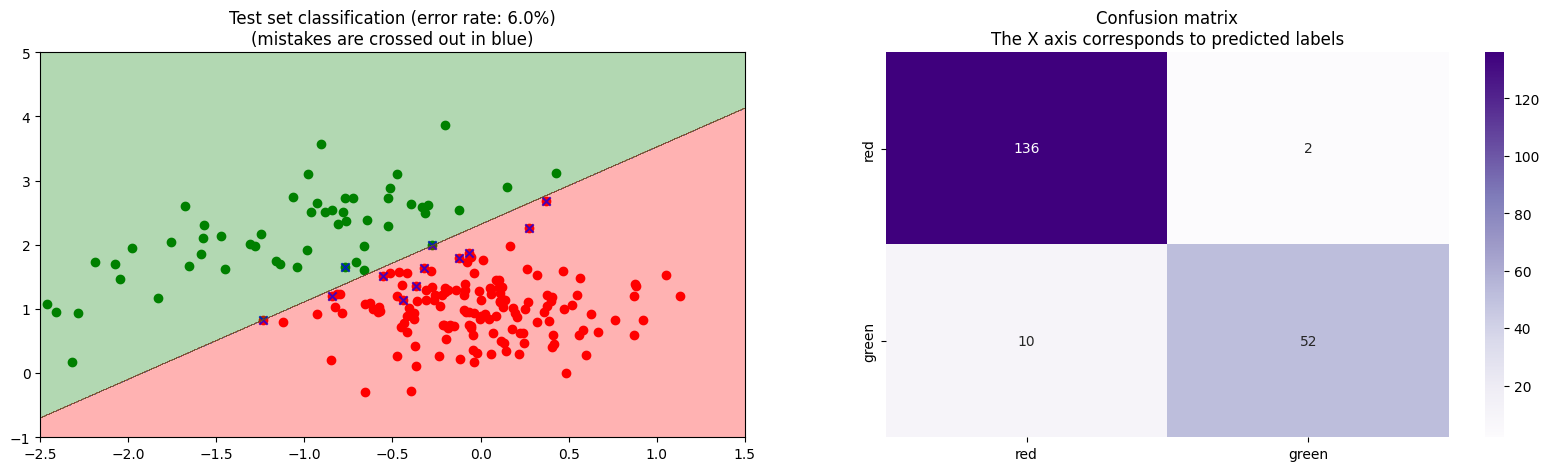

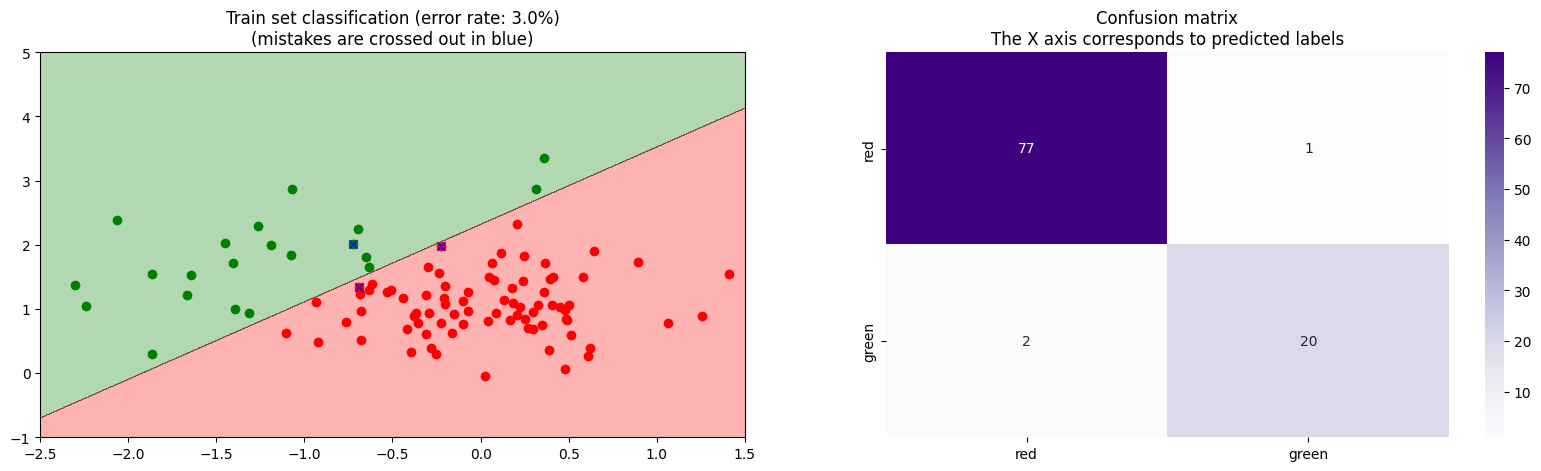

In [9]:
x1_bounds=(-2.5, 1.5)
x2_bounds=(-1, 5)
figsize=(20,5)

logReg = LogisticRegression(X, t)

# Results for the test set
classification_test = BinaryPointsClassification(X_test, t_test, logReg.predict)
classification_test.display_prediction(x1_bounds, x2_bounds, resolution = 1000, title = f"Test set classification (error rate: {classification_test.error_rate*100}%)")

# Results for the training set
classification_train = BinaryPointsClassification(X, t, logReg.predict)
classification_train.display_prediction(x1_bounds, x2_bounds, resolution = 1000, figsize = figsize, title = f"Train set classification (error rate: {classification_train.error_rate*100}%)")

We observe that the classifier makes a lot more mistakes on class 1 (green points) than class 0 (red points) on the test set. That's because there were not enough green points in the training set to be able to learn their repartition properly : only 31% of points were of class 1 vs. 69% of class 0, there is a clear imbalance that causes overfitting on red points.

## Q4: Equation of the decision boundary

The decision boundary corresponds to the $(x1,x2)$ couples such that $\sigma(w^T x) = 0.5$. In other words:  $w_0 + w_1 x_1 + w_2 x_2 = 0 $.


More generally, for a threshold $\tau$, we need $\sigma(w^T x) = \tau$, hence $w_0 + w_1 x_1 + w_2 x_2 = logit(\tau)$

### Q5: Add a few points away from the decision boundary

In [10]:
nb_points = 10
outliers = np.stack([np.ones(nb_points), np.linspace(3,4,nb_points), np.linspace(-1,0,nb_points)]).T # generate 10 points far from the decision boundary

X_outliers = np.vstack([X, outliers])
t_outliers = np.hstack([t, np.zeros(nb_points)]) # all added points are in class 0

In [11]:
# Training the LDA model

lda = LinearDiscriminantAnalysis()
lda.fit(X_outliers, t_outliers)

LinearDiscriminantAnalysis()

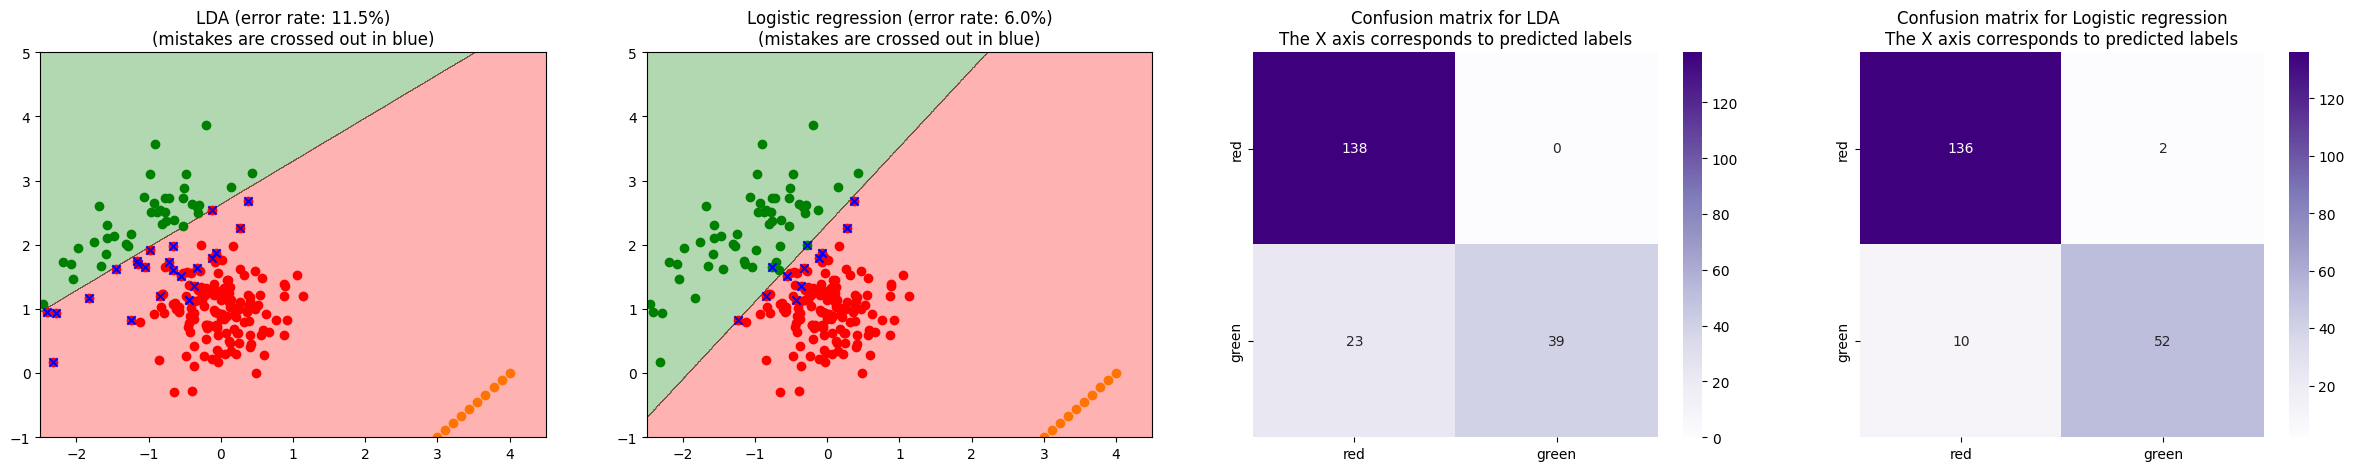

In [13]:
# Displaying results

x1_bounds = (-2.5, 4.5)
x2_bounds=(-1, 5)

classification_outliers = BinaryPointsClassification(X_test, t_test, logReg.predict)
classification_outliers_lda = BinaryPointsClassification(X_test, t_test, lda.predict)

plt.figure(figsize=(30,5))

plt.subplot(141)
plt.scatter(outliers[:,1], outliers[:,2], c='orange')
classification_outliers_lda.decision_regions_figure(x1_bounds, x2_bounds)
classification_outliers_lda.predicted_points_figure(title=f"LDA (error rate: {classification_outliers_lda.error_rate*100}%)")

plt.subplot(142)
plt.scatter(outliers[:,1], outliers[:,2], c='orange')
classification_outliers.decision_regions_figure(x1_bounds, x2_bounds)
classification_outliers.predicted_points_figure(title=f"Logistic regression (error rate: {classification_outliers.error_rate*100}%)")

plt.subplot(143)
plt.title("Confusion matrix for LDA\nThe X axis corresponds to predicted labels")
classification_outliers_lda.confusion_matrix_heatmap()

plt.subplot(144)
plt.title("Confusion matrix for Logistic regression\nThe X axis corresponds to predicted labels")
classification_outliers.confusion_matrix_heatmap()


As expected, we observe that LDA is way more sensitive to outliers than logistic regression: the boundary decision starts leaning towards them, causing many mistakes on green points (class 1). However, the error rate doesn't change for logistic regression: this shows the robustness of this method over LDA.

### Extra: Cross-validation

In order to better estimate the error rate and find an optimal threshold, we realize a cross validation. We will test 50 values between 0.4 and 0.6.

In [ ]:
# We need to make an object that sklearn can use

def sigma(a): return 1/(1+np.exp(-a)) # sigmoid function

class LogisticRegressionCV():
    
    def __init__(self, threshold = 0.5, Nitermax = 50, eps_conv = 1e-3):
        self.threshold = threshold
        self.Nitermax = Nitermax
        self.eps_conv = eps_conv
    
    def fit(self, train_data, train_target):
        self.train_data = train_data
        self.train_target = train_target
        self.coefs, self.Niter = self.__get_coeffs()
        return self
        
    def __get_coeffs(self):
        return regression_logistique(self.train_data, self.train_target, self.Nitermax, self.eps_conv)
    
    def get_params(self, deep):
        return {'threshold' : self.threshold}
        
    def predict(self, test_data):
        pred = sigma(test_data.dot(self.coefs))
        return np.where(pred >= self.threshold, 1, 0)
    
      
# Scorer function that will be used for cross-validation (= error rate)

def score_func(y, y_pred, **kwargs):
    N = len(y)
    error = sum(abs(y_pred-y))/N
    return error
    
scorer = skl.metrics.make_scorer(score_func)

In [ ]:
# We regroup all data into two lists that will be split during cross-validation. We do not shuffle them because we expect sklearn to do it.

X_all = np.vstack([X, X_test])
t_all = np.vstack([t.reshape(len(t), 1), t_test.reshape(len(t_test), 1)])
t_all = t_all.reshape(len(t_all),)

In [ ]:
# sklearn cross-validation
from sklearn.model_selection import cross_val_score

folds = 10
first_threshold, last_threshold, number_threshold = 0.4, 0.6, 50

# first iteration
lr = LogisticRegressionCV(first_threshold)
best_score = np.mean(cross_val_score(lr, X_all, t_all, cv=folds, scoring=scorer))
best_threshold = first_threshold

thresholds = []
scores = []

# iterations where the threshold varies
for threshold in np.linspace(first_threshold, last_threshold, number_threshold):
    lr = LogisticRegressionCV(threshold)
    mean_score = np.mean(cross_val_score(lr, X_all, t_all, cv=folds, scoring=scorer))
    
    thresholds.append(threshold)
    scores.append(mean_score)
    
    if(mean_score < best_score):
        best_threshold = threshold
        best_score = mean_score

print(f"The lowest error rate {round(best_score*100, 2)}% was found for threshold {round(best_threshold, 3)}.")

plt.title("Variation of the mean score in cross-validation depending on the threshold")
plt.xlabel("Threshold")
plt.ylabel("Mean error rate")
plt.plot(thresholds, scores)


With cross-validation we find that a threshold under the "default" of 0.5 gives better results on average.

We will now retry to predict the classification on the initial test set using this optimized threshold.

In [ ]:
lr_best = LogisticRegressionCV(best_threshold).fit(X, t)

x1_bounds=(-2.5, 1.5)
x2_bounds=(-1, 5)
figsize=(20,5)

cv_classification = BinaryPointsClassification(X_test, t_test, lr_best.predict)
cv_classification.display_prediction(x1_bounds, x2_bounds, resolution = 1000, title = f"Test set classification with optimized threshold (error rate: {cv_classification.error_rate*100}%)")

Previously, the error rate was 6%. Now it has gone down to 5.5%: the threshold optimization helped improving the results.

To have even more precise results, with more time we could try to re-run the cross-validation with a number of folds equal to the dataset size, which could possibly help find an even better threshold.

## 2. Application: handwritten digits recognition 5 & 6
We load 2 matrices which contain each a sequence of examples of 16x16 images 
of handwritten digits which are 5 and 6 here. Each line of the matrix
contains 256 pixel values coding for the gray level of a 16x16 image.

In [ ]:
train_5 = np.loadtxt('train_5.txt',delimiter=',')   # 556 samples
train_6 = np.loadtxt('train_6.txt',delimiter=',')   # 664 samples

### Examples of images

In [ ]:
# Digit 5
n=9
I = np.reshape(train_5[n,:],(16,16))

plt.imshow(I,cmap='gray')
plt.show()

In [ ]:
# Digit 6
n=4
I = reshape(train_6[n,:],(16,16))

plt.imshow(I,cmap='gray')
plt.show()

### Separating the training and test sets

We keep in the training set the 145 first images of 5s and the 200 first
images of 6s:

In [ ]:
x_train_brut = np.vstack((train_5[:145,:], train_6[:200,:]))
N_train = np.size(x_train_brut,axis=0)
class_train = np.ones((345,)) # label 1 for digit 6
class_train[:145] = 0 # label 0 for digit 5

x_test_brut = np.vstack((train_5[145:,:], train_6[200:,:]))
N_test = np.size(train_5,axis=0)+np.size(train_6,axis=0)-N_train
class_test = np.ones((875,)) # label 1 for digit 6
class_test[:410] = 0 # label 0 for digit 5

## Exercise 2: logistic regression to classify 5 & 6

1. Note that pixel values are between -1 and 1 by using the functions
 `min(I(:))` and `max(I(:))`.
2. Identify the indices of the most significant pixels, which are defined 
as having a standard deviation greater than 0.5 here. We denote by `lis_sig`
the list of positions of these significant pixels in the image vector.
_Indication : the function `std` gives the standard deviation (columnwise
in matrices) and you should find 173 pixel positions.
3. Show a binary image to locate these pixels.
_Indication : `Isig = zeros(16); Isig(list_sig)=1; Isig=Isig';`._
4. Define the training set `x_train` from `x_train_brut` from the significant pixels only.
5. Do the same with `x_test_brut` to extract `x_test`.
6. Use `regression_logistique.m` to estimate the logistic regression vector
`w` from the training set `x_train`. 
Choose `Nitermax = 13; eps_conv = 1e-3;`
7. Compute the decision function and the labels of the test set `x_test`. 
_Indication : do not forget the column of ones !_
8. Estimate the classification error rate by using :
`erreur = sum(abs(class-class_test))/N_test;`.
9. Locate some misclassified examples and visualize the corresponding image.
Comment on your results and observations.

### Q1: Minimum and maximum pixel values

In [ ]:
print(f"The pixel values are between {np.min(I[:])} and {np.max(I[:])}.")

### Q2: Identify the most significant pixels + Q3: Display a binary image to locate these pixels

In [14]:
std = np.std(x_train_brut, axis=0)

I_std_heat = std.reshape((16,16))

std_bin = np.array([std>0.5])[0]
I_std_bin = std_bin.reshape((16,16))

plt.figure(figsize=(13,4.6))
plt.subplot(121)
plt.title("Standard deviation for each pixel over the entire dataset")
sns.heatmap(I_std_heat)

plt.subplot(122)
plt.title(f"Display of the {sum(std_bin)} most important pixels (std>0.5)")
sns.heatmap(I_std_bin)

NameError: name 'x_train_brut' is not defined

The pixels that have the highest standard deviation are located in such a way that we could fit 5's and 6's in the "silhouette" that is produced from the heatmap. Understandably, we recognize the round shape that is common to 5 and 6 at the bottom of the image, among other common features. This translates well the fact that those pixels are the ones that are important to look at when it comes to identifying the two numbers.

Out of curiosity, we also display the most significant pixels for 5's and 6's individually.

In [ ]:
std_5 = np.std(train_5, axis=0)
std_6 = np.std(train_6, axis=0)

plt.figure(figsize=(13,4.6))
plt.subplot(121)
plt.title("Standard deviation for each pixel in the 5's dataset")
sns.heatmap(std_5.reshape((16,16)))

plt.subplot(122)
plt.title("Standard deviation for each pixel in the 6's dataset")
sns.heatmap(std_6.reshape((16,16)))

Expectedly, we observe that the "significant" (high variance) features are different from the heatmap observed before: each number is represented more accurately.

### Q4 and Q5: Define the training and test sets

In [ ]:
x_train = x_train_brut[:, std_bin]
x_test = x_test_brut[:, std_bin]

print(f"The number of columns in x_train was reduced to {x_train.shape[1]}.")
print(f"The number of columns in x_test was reduced to {x_test.shape[1]}.")

### Q6: Estimate the logistic regression vector

In [ ]:
Nitermax = 13
eps_conv = 1e-3

x_train_t = np.hstack((np.ones((N_train,1)),x_train)) # 't' for 'tilde' since we are adding a column of 1's
x_test_t = np.hstack((np.ones((N_test,1)),x_test))

logRegNumbers = LogisticRegression(x_train_t, class_train, Nitermax = Nitermax, eps_conv = eps_conv)

# The logistic regression vector is given by
w = logRegNumbers.coefs

print(f"The logistic regression vector is of shape {w.shape} (includes coefs for 173 most significant pixels and bias)")

Note on `Nitermax` and `eps_conv`: we inadvertently had forgotten to use the recommended values, which resulted in an error thrown by `regression_logistique`: "Not a Singular Matrix". This highlights the importance of these parameters.

### Q7: Compute the prediction + Q8: Estimate the error rate

In [ ]:
prediction = logRegNumbers.predict(x_test_t)

error = sum(abs(prediction-class_test))/N_test
print(f"The estimated error rate for the numbers prediction is {error*100}%.")

skl.metrics.ConfusionMatrixDisplay.from_predictions(class_test, prediction, cmap=plt.cm.Purples)

The confusion matrix shows that the predictor made 70 mistakes:
- 45 5's were labelled as 6's, which represents an error rate of $45/410 \approx 11 \%$
- 25 6's were labelled as 5's, which represents an error rate of $25/465 \approx 5.4 \%$
  
Meaning that proportionally, more mistakes were made on 5's. This result seems to reflect the fact that there were more 6's than 5's (over 30% more, in fact) in the training set. This results in a system that seems very capable of recognizing 6's, but has been insufficiently trained to recognize 5's: it is a form of overfitting.

### Q9: Display and comment on some of the mistakes

In [ ]:
error_mask = abs(prediction-class_test)
error_mask = error_mask.astype(int)
mistakes = x_test_brut[error_mask==1]

def display_image(data, index):
    img = reshape(data[index,:],(16,16))
    plt.imshow(img,cmap='gray')


In [ ]:
nb_to_display = 9 # must be lower than 10 for the next loops to manage subplots properly
offset = 0 # modify to display different parts of the misclassed numbers (must not be too high)

plt.figure(figsize=(15,5))

for i in range(1, nb_to_display+1):
    plt.subplot(100 + nb_to_display*10 + i)
    display_image(mistakes, offset + i) # the first elements are wrongly guessed 5's
    
    
plt.figure(figsize=(15,5))
for i in range(1, nb_to_display+1):
    plt.subplot(100 + nb_to_display*10 + i)
    display_image(mistakes, -offset - i) # the last elements are wrongly guessed 6's

From a very subjective point of view, it seems understandable that some of the above 5's were mistaken for 6's. For the first ones in particular, the "gap" to the bottom left is sometimes very small, which could be a reason to mistake a 5 for a 6. For the 6's that were mistaken as 5's, the prediction seems to make a little less sense. On the sample of mistakes we drew, most of them seem to have in common a "counter-clockwise rotation", which is hard to interpret without studying the training set in more depth.

## 3. Logistic regression using `scikit-learn`

1. **Go to** http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html for a presentation of the logistic regression model in `scikit-learn`.

2. **Apply** it to the present data set.

3. **Comment** on the use of logistic regression.

*Indication : you may have a look at* 

a) Theory : http://openclassroom.stanford.edu/MainFolder/DocumentPage.php?course=MachineLearning&doc=exercises/ex5/ex5.html

b) Video :  https://www.coursera.org/learn/machine-learning/lecture/4BHEy/regularized-logistic-regression 

c) Example : http://scikit-learn.org/stable/auto_examples/exercises/plot_digits_classification_exercise.html#sphx-glr-auto-examples-exercises-plot-digits-classification-exercise-py

*for a short presentation of regularized logistic regression.*

In [ ]:
# Linear regression with penalty
from sklearn.linear_model import LogisticRegression as SkLearnLogisticRegression
sk_learn_lr = SkLearnLogisticRegression().fit(x_train_t, class_train)
prediction_sklearn = sk_learn_lr.predict(x_test_t)

error_sklearn = sum(abs(prediction_sklearn-class_test))/N_test
print(f"With sklearn, the estimated error rate for the numbers of prediction is {error_sklearn*100}%.")

skl.metrics.ConfusionMatrixDisplay.from_predictions(class_test, prediction_sklearn, cmap=plt.cm.Purples)

We observe that sklearn manages to make better prediction than our own implementation of logistic regression. Indeed, sklearn uses regularized logistic regression which helps reduce the overfitting caused by the imbalance between the number of 5s and the number of 6s. 

Let's compute sklearn's logistic regression without penalty to make sure that regularization is actually what improves the performance.

In [ ]:
# Linear regression without penalty
sk_learn_lr_no_penalty = SkLearnLogisticRegression(penalty='none').fit(x_train_t, class_train)
prediction_sklearn_no_penalty = sk_learn_lr_no_penalty.predict(x_test_t)

error_sklearn_no_penalty = sum(abs(prediction_sklearn_no_penalty-class_test))/N_test
print(f"With sklearn without the penalty, the estimated error rate for the numbers of prediction is {error_sklearn_no_penalty*100}%.")

skl.metrics.ConfusionMatrixDisplay.from_predictions(class_test, prediction_sklearn_no_penalty, cmap=plt.cm.Purples)

We observe that, as expected, sklearn's prediction is slightly worse without regularization. However, it is still better than ours: it might be because sklearn uses some kind of optimization to improve predictions (e.g. an optimization of the threshold), or because of an implementation error on our part.